Instalación de librerías utilizadas

In [1]:
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘Rcpp’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’




In [2]:
install.packages("e1071")
install.packages("readr")
install.packages("data.table")
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Carga de librerías utilizadas

In [8]:
library(e1071) #Modelo predictivo Naive Bayes
library(readr)
library(dplyr) #transformación de datos
library(data.table) #Operaciones con datos tabulares
library(ggplot2) #Gráficos
library(caret) #"Classification And REgression Training" Herramientas para modelos predictivos (utilizamos las métricas de evaluación)

Carga del Dataset

In [4]:
Sys.setenv("KAGGLE_USERNAME" = "csarherczog", "KAGGLE_KEY" = "c5e2b376df42a74c3000bbe34de2ce9b")

In [5]:
# Descargar dataset de Kaggle
system("kaggle datasets download -d ealaxi/paysim1", intern = TRUE)

[1] "Downloading paysim1.zip to /content" ""

In [6]:
# Descomprimir el archivo .zip
zip_file <- "paysim1.zip"
unzip(zip_file)

In [9]:
# Cargar los datos desde el .csv
datos <- read_csv("/content/PS_20174392719_1491204439457_log.csv");

Rows: 6362620 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): type, nameOrig, nameDest
dbl (8): step, amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbal...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Análisis del dataset

In [10]:
# Mostrar las primeras líneas del dataset
head(datos)

step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,PAYMENT,9839.64,C1231006815,170136,160296.36,M1979787155,0,0,0,0
1,PAYMENT,1864.28,C1666544295,21249,19384.72,M2044282225,0,0,0,0
1,TRANSFER,181.00,C1305486145,181,0.00,C553264065,0,0,1,0
1,CASH_OUT,181.00,C840083671,181,0.00,C38997010,21182,0,1,0
1,PAYMENT,11668.14,C2048537720,41554,29885.86,M1230701703,0,0,0,0
1,PAYMENT,7817.71,C90045638,53860,46042.29,M573487274,0,0,0,0


In [11]:
# Dar a los datos formato de tabla
datos <- as.data.table(datos)

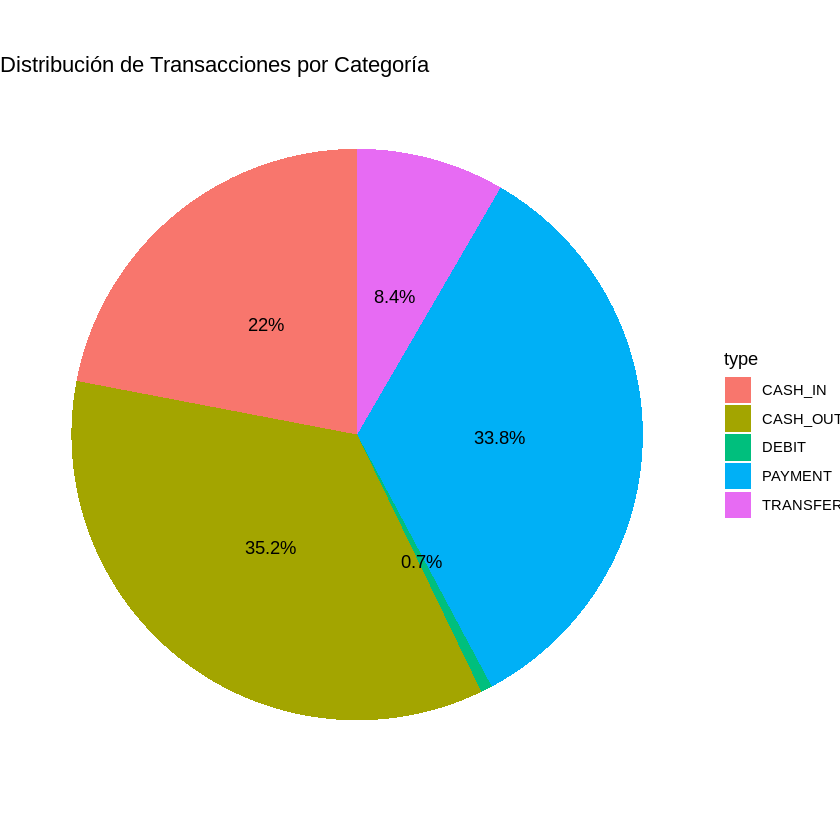

In [12]:
# Contar la frecuencia de cada categoría
conteo_por_tipo <- datos[, .N, by = type]

# Calcular el porcentaje del total
conteo_por_tipo[, porcentaje := N / sum(N) * 100]

# Gráfico de torta con etiquetas de porcentaje
ggplot(conteo_por_tipo, aes(x = "", y = porcentaje, fill = type, label = paste0(round(porcentaje, 1), "%"))) +
  geom_bar(stat = "identity", width = 1) +
  geom_text(position = position_stack(vjust = 0.5)) +
  coord_polar(theta = "y") +
  theme_void() +
  ggtitle("Distribución de Transacciones por Categoría")

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


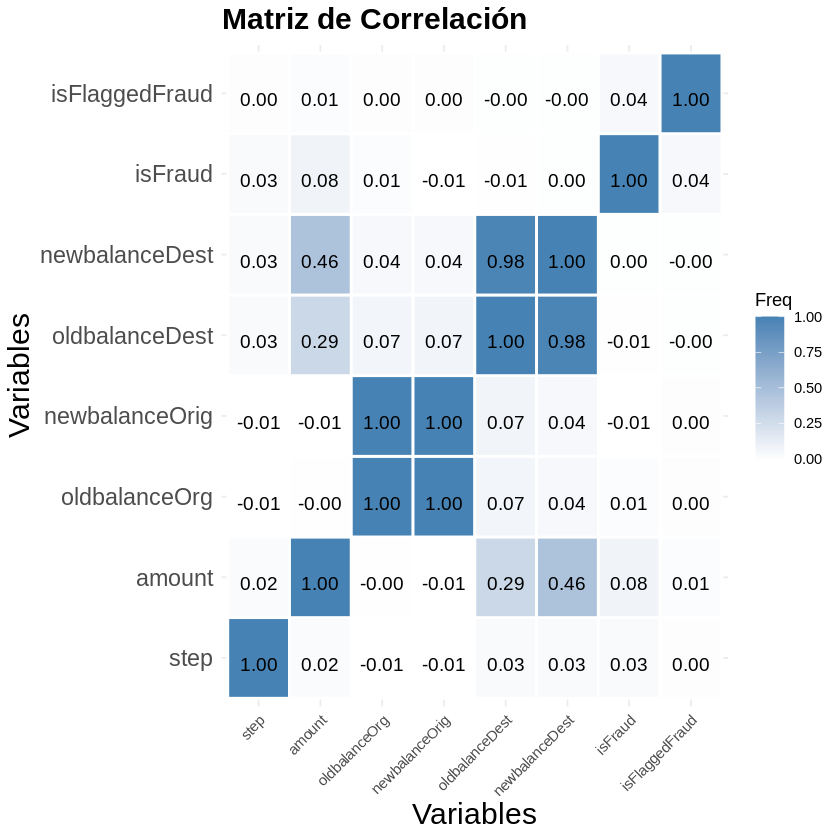

In [13]:
# Calcula la matriz de correlación
matriz_cor <- cor(datos[, -c("type", "nameOrig", "nameDest")])

# Matriz de correlación con ggplot2
ggplot(data = as.data.frame(as.table(matriz_cor)),
       aes(Var1, Var2, fill = Freq)) +
  geom_tile(color = "white", size = 0.8) +
  geom_text(aes(label = sprintf("%.2f", Freq)), vjust = 1, size = 4) +
  scale_fill_gradient(low = "white", high = "steelblue") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.text.y = element_text(size = 14),
        plot.title = element_text(size = 18, face = "bold"),
        axis.title = element_text(size = 18)) +
  labs(title = "Matriz de Correlación",
       x = "Variables",
       y = "Variables");

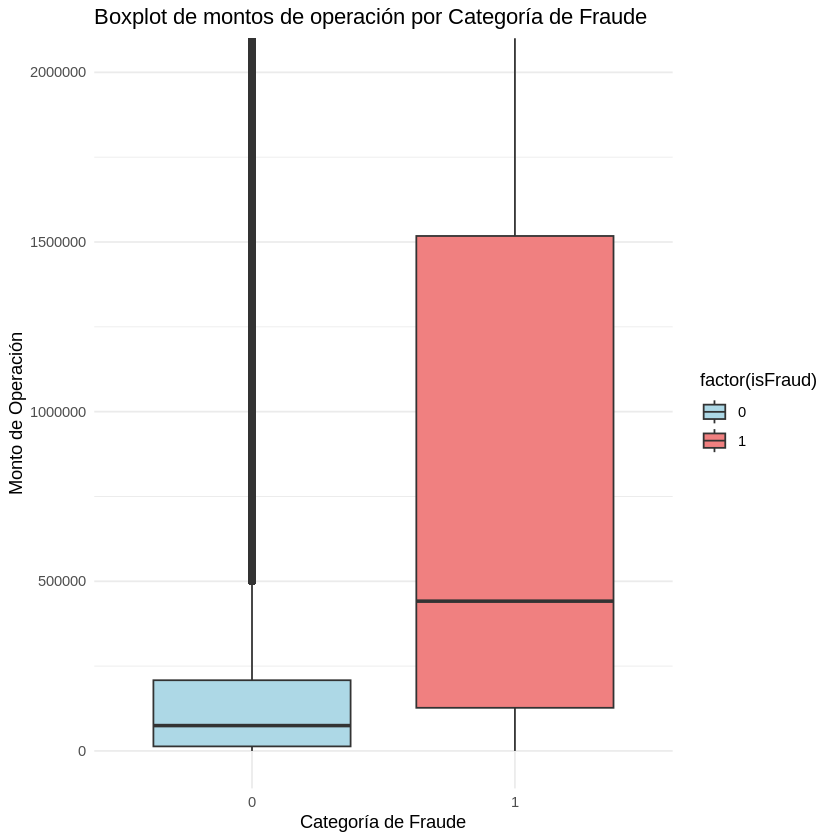

In [14]:
ggplot(datos, aes(x = as.factor(isFraud), y = amount, fill = factor(isFraud))) +
  geom_boxplot() +
  scale_fill_manual(values = c("0" = "lightblue", "1" = "lightcoral")) +
  labs(title = "Boxplot de montos de operación por Categoría de Fraude",
       x = "Categoría de Fraude",
       y = "Monto de Operación") +
  theme_minimal() +
  coord_cartesian(ylim = c(-10000, 2000000))

Creación de nuevas variables

In [15]:
datos[, Tatal_transfer := ifelse(amount == oldbalanceOrg, 1, 0)]

In [16]:
datos[, Large_transfer := ifelse(amount >= 20000, 1, 0)]

In [17]:
datos[, Very_large_transfer := ifelse(amount >= 50000, 1, 0)]

In [18]:
datos$type <- as.factor(datos$type)

Separación de los datos en Entrenamiento y Prueba

In [19]:
# Separar los datos en conjunto de entrenamiento y prueba
set.seed(42)
porcentaje_entrenamiento <- 0.8
indices_entrenamiento <- sample(1:nrow(datos), round(porcentaje_entrenamiento * nrow(datos)))
conjunto_entrenamiento <- datos[indices_entrenamiento, ]
conjunto_prueba <- datos[-indices_entrenamiento, ]

In [22]:
head(conjunto_entrenamiento)

step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Tatal_transfer,Large_transfer,Very_large_transfer
<dbl>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
249,CASH_OUT,248079.60,C749021765,0.0,0.0,C1073261833,355793.6,603873.19,0,0,0,1,1
306,PAYMENT,5616.96,C1473432842,229267.6,223650.6,M1538113258,0.0,0.00,0,0,0,0,0
346,PAYMENT,35540.62,C143131489,105.0,0.0,M2134239009,0.0,0.00,0,0,0,1,0
130,CASH_IN,254779.05,C1980677138,2610731.2,2865510.2,C1437068360,545006.1,290227.08,0,0,0,1,1
241,CASH_IN,241867.12,C1604163664,152867.5,394734.7,C1069274290,273232.8,31365.63,0,0,0,1,1
234,CASH_IN,212213.35,C1689276201,2011963.2,2224176.6,C1935637582,261767.9,49554.57,0,0,0,1,1


In [25]:
# Se elimina isFraud conjunto de prueba
conjunto_prueba_sin_isFraud <- subset(conjunto_prueba, select = -isFraud)

# Se verificar la eliminación
str(conjunto_prueba_sin_isFraud)

Classes ‘data.table’ and 'data.frame':	1272524 obs. of  13 variables:
 $ step               : num  1 1 1 1 1 1 1 1 1 1 ...
 $ type               : Factor w/ 5 levels "CASH_IN","CASH_OUT",..: 4 3 4 4 5 4 4 4 4 4 ...
 $ amount             : num  7818 9645 3100 672 215310 ...
 $ nameOrig           : chr  "C90045638" "C1900366749" "C249177573" "C2033524545" ...
 $ oldbalanceOrg      : num  53860 4465 20771 15123 705 ...
 $ newbalanceOrig     : num  46042 0 17671 14451 0 ...
 $ nameDest           : chr  "M573487274" "C997608398" "M2096539129" "M473053293" ...
 $ oldbalanceDest     : num  0 10845 0 0 22425 ...
 $ newbalanceDest     : num  0 157982 0 0 0 ...
 $ isFlaggedFraud     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Tatal_transfer     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Large_transfer     : num  0 0 0 0 1 0 0 0 0 0 ...
 $ Very_large_transfer: num  0 0 0 0 1 0 0 0 0 0 ...
 - attr(*, "spec")=
  .. cols(
  ..   step = col_double(),
  ..   type = col_character(),
  ..   amount = col_double(),
  ..   n

In [23]:
head(conjunto_prueba)

step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Tatal_transfer,Large_transfer,Very_large_transfer
<dbl>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,PAYMENT,7817.71,C90045638,53860,46042.29,M573487274,0,0.0,0,0,0,0,0
1,DEBIT,9644.94,C1900366749,4465,0.00,C997608398,10845,157982.1,0,0,0,0,0
1,PAYMENT,3099.97,C249177573,20771,17671.03,M2096539129,0,0.0,0,0,0,0,0
1,PAYMENT,671.64,C2033524545,15123,14451.36,M473053293,0,0.0,0,0,0,0,0
1,TRANSFER,215310.30,C1670993182,705,0.00,C1100439041,22425,0.0,0,0,0,1,1
1,PAYMENT,9478.39,C1671590089,116494,107015.61,M58488213,0,0.0,0,0,0,0,0


Entrenamiento del modelo predictivo

In [24]:
modelo_nb <- naiveBayes(isFraud ~ type + amount + oldbalanceOrg + newbalanceOrig + oldbalanceDest + newbalanceDest + Tatal_transfer + Large_transfer + Very_large_transfer , data = conjunto_entrenamiento, , )laplace = 1

Predicción

In [26]:
# Realizar predicciones en el conjunto de prueba
predicciones <- predict(modelo_nb, conjunto_prueba_sin_isFraud)

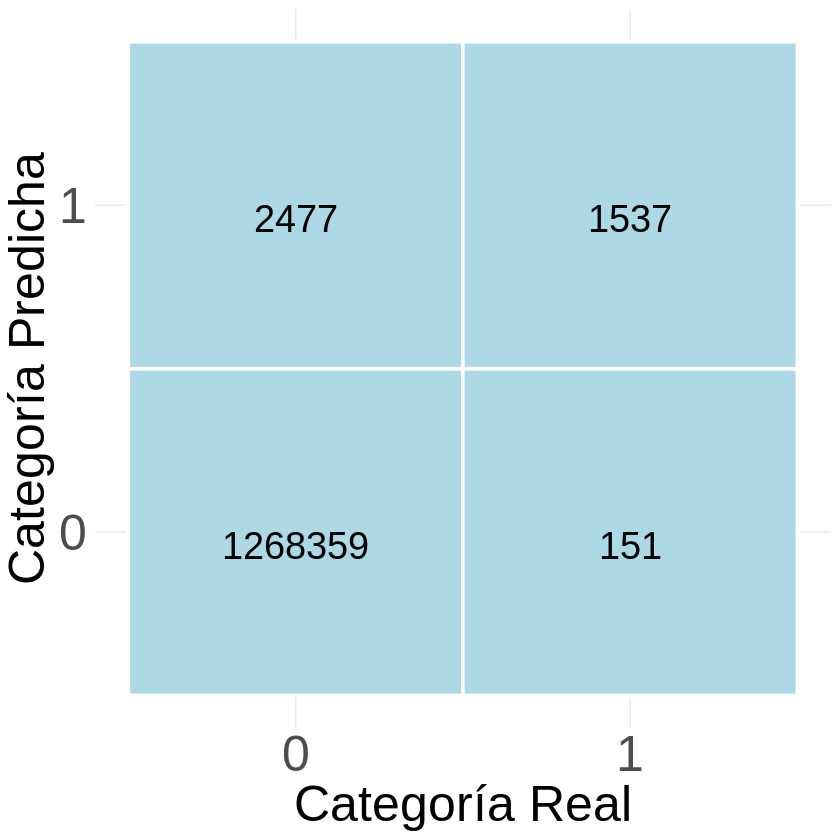

In [28]:
# Crear la matriz de confusión
matriz_confusion <- table(Real = conjunto_prueba$isFraud, Prediccion = predicciones)

# Convertir la matriz de confusión a un data frame
matriz_confusion_df <- as.data.frame(as.table(matriz_confusion))

# Matriz de confusión con ggplot2
ggplot(matriz_confusion_df, aes(x = Real, y = Prediccion, fill = "SameColor")) +
  geom_tile(color = "white", size = 1) +
  geom_text(aes(label = sprintf("%d", Freq)), vjust = 1, size = 8) +  # Ajusta el tamaño del texto
  scale_fill_manual(values = "lightblue") +
  theme_minimal() +
  theme(axis.text = element_text(size = 30),
        axis.title = element_text(size = 30),
        legend.position = "none") +
  labs(x = "Categoría Real",
       y = "Categoría Predicha")

In [29]:
# Convertir la matriz a una tabla de contingencia
tabla_contingencia <- as.table(matriz_confusion)

# Calcular métricas
metricas <- confusionMatrix(tabla_contingencia)

# Imprimir las métricas
print(metricas)


Confusion Matrix and Statistics

    Prediccion
Real       0       1
   0 1268359    2477
   1     151    1537
                                         
               Accuracy : 0.9979         
                 95% CI : (0.9979, 0.998)
    No Information Rate : 0.9968         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.5382         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.9999         
            Specificity : 0.3829         
         Pos Pred Value : 0.9981         
         Neg Pred Value : 0.9105         
             Prevalence : 0.9968         
         Detection Rate : 0.9967         
   Detection Prevalence : 0.9987         
      Balanced Accuracy : 0.6914         
                                         
       'Positive' Class : 0              
                                         
